In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import os
from IPython.display import display

In [ ]:
news_djia = pd.read_csv('./Combined_News_DJIA.csv')
print(news_djia.shape)
news_djia.head(2)

(1989, 27)


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [ ]:
news_djia = news_djia.drop(labels='Label', axis=1)

# Some column values are not in string so convert them
news_djia = news_djia.apply(lambda x: x.map(lambda y: str(y)), axis=1)

# Remove starting b' and b" characters
news_djia = news_djia.apply(lambda x: x.map(lambda y: y.replace('b"', '').replace("b'", '').replace('"', '')), axis=1)

# Set each strings of articles to list of articles for bert_embedding
news_djia.iloc[:, 1:] = news_djia.iloc[:, 1:].apply(lambda x: x.map(lambda y: [y]), axis=1)

# Move Date to Index
news_djia = news_djia.set_index(news_djia.iloc[:, 0]).drop('Date', axis=1)

In [ ]:
news_djia.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,[Georgia 'downs two Russian warplanes' as coun...,[BREAKING: Musharraf to be impeached.'],[Russia Today: Columns of troops roll into Sou...,[Russian tanks are moving towards the capital ...,"[Afghan children raped with 'impunity,' U.N. o...",[150 Russian tanks have entered South Ossetia ...,"[Breaking: Georgia invades South Ossetia, Russ...",[The 'enemy combatent' trials are nothing but ...,[Georgian troops retreat from S. Osettain capi...,[Did the U.S. Prep Georgia for War with Russia?'],[Rice Gives Green Light for Israel to Attack I...,[Announcing:Class Action Lawsuit on Behalf of ...,[So---Russia and Georgia are at war and the NY...,[China tells Bush to stay out of other countri...,[Did World War III start today?'],[Georgia Invades South Ossetia - if Russia get...,[Al-Qaeda Faces Islamist Backlash'],[Condoleezza Rice: The US would not act to pre...,[This is a busy day: The European Union has a...,"[Georgia will withdraw 1,000 soldiers from Ira...",[Why the Pentagon Thinks Attacking Iran is a B...,[Caucasus in crisis: Georgia invades South Oss...,[Indian shoe manufactory - And again in a ser...,[Visitors Suffering from Mental Illnesses Bann...,[No Help for Mexico's Kidnapping Surge]
2008-08-11,[Why wont America and Nato help us? If they wo...,[Bush puts foot down on Georgian conflict'],[Jewish Georgian minister: Thanks to Israeli t...,[Georgian army flees in disarray as Russians a...,[Olympic opening ceremony fireworks 'faked'],[What were the Mossad with fraudulent New Zeal...,[Russia angered by Israeli military sale to Ge...,[An American citizen living in S.Ossetia blame...,[Welcome To World War IV! Now In High Definiti...,"[Georgia's move, a mistake of monumental propo...",[Russia presses deeper into Georgia; U.S. says...,[Abhinav Bindra wins first ever Individual Oly...,[ U.S. ship heads for Arctic to define territo...,[Drivers in a Jerusalem taxi station threaten ...,[The French Team is Stunned by Phelps and the ...,[Israel and the US behind the Georgian aggress...,"[Do not believe TV, neither Russian nor Georgi...",[Riots are still going on in Montreal (Canada)...,[China to overtake US as largest manufacturer'],[War in South Ossetia [PICS]'],[Israeli Physicians Group Condemns State Tortu...,[ Russia has just beaten the United States ove...,[Perhaps *the* question about the Georgia - Ru...,[Russia is so much better at war'],[So this is what it's come to: trading sex for...


In [ ]:
!pip install mxnet
!pip install gluonnlp
!pip install mxnet-cu101
import mxnet as mx
from mxnet import gluon
from embedding import BertEmbedding

# Get GPU
ctx = mx.gpu()

# Define a model in GPU for faster training
bert_embedding = BertEmbedding(model='bert_12_768_12', dataset_name='book_corpus_wiki_en_cased', ctx=ctx)

In [ ]:
example_embedding = news_djia.iloc[:2, :].apply(lambda x: x.map(lambda y: bert_embedding(y)))
example_embedding

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,"[([Georgia, ', downs, two, Russian, warplanes,...","[([BREAKING, :, Musharraf, to, be, impeached, ...","[([Russia, Today, :, Columns, of, troops, roll...","[([Russian, tanks, are, moving, towards, the, ...","[([Afghan, children, raped, with, ', impunity,...","[([150, Russian, tanks, have, entered, South, ...","[([Breaking, :, Georgia, invades, South, Osset...","[([The, ', enemy, combatent, ', trials, are, n...","[([Georgian, troops, retreat, from, S, ., Oset...","[([Did, the, U, ., S, ., Prep, Georgia, for, W...","[([Rice, Gives, Green, Light, for, Israel, to,...","[([Announcing, :, Class, Action, Lawsuit, on, ...","[([So, -, -, -, Russia, and, Georgia, are, at,...","[([China, tells, Bush, to, stay, out, of, othe...","[([Did, World, War, III, start, today, ?, '], ...","[([Georgia, Invades, South, Ossetia, -, if, Ru...","[([Al, -, Qaeda, Faces, Islamist, Backlash, ']...","[([Condoleezza, Rice, :, The, US, would, not, ...","[([This, is, a, busy, day, :, The, European, U...","[([Georgia, will, withdraw, 1, ,, 000, soldier...","[([Why, the, Pentagon, Thinks, Attacking, Iran...","[([Caucasus, in, crisis, :, Georgia, invades, ...","[([Indian, shoe, manufactory, -, And, again, i...","[([Visitors, Suffering, from, Mental, Illnesse...","[([No, Help, for, Mexico, ', s, Kidnapping, Su..."
2008-08-11,"[([Why, wont, America, and, Nato, help, us, ?,...","[([Bush, puts, foot, down, on, Georgian, confl...","[([Jewish, Georgian, minister, :, Thanks, to, ...","[([Georgian, army, flees, in, disarray, as, Ru...","[([Olympic, opening, ceremony, fireworks, ', f...","[([What, were, the, Mossad, with, fraudulent, ...","[([Russia, angered, by, Israeli, military, sal...","[([An, American, citizen, living, in, S, ., Os...","[([Welcome, To, World, War, IV, !, Now, In, Hi...","[([Georgia, ', s, move, ,, a, mistake, of, mon...","[([Russia, presses, deeper, into, Georgia, ;, ...","[([Abhinav, Bindra, wins, first, ever, Individ...","[([U, ., S, ., ship, heads, for, Arctic, to, d...","[([Drivers, in, a, Jerusalem, taxi, station, t...","[([The, French, Team, is, Stunned, by, Phelps,...","[([Israel, and, the, US, behind, the, Georgian...","[([Do, not, believe, TV, ,, neither, Russian, ...","[([Riots, are, still, going, on, in, Montreal,...","[([China, to, overtake, US, as, largest, manuf...","[([War, in, South, Ossetia, [, PICS, ], '], [[...","[([Israeli, Physicians, Group, Condemns, State...","[([Russia, has, just, beaten, the, United, Sta...","[([Perhaps, *, the, *, question, about, the, G...","[([Russia, is, so, much, better, at, war, '], ...","[([So, this, is, what, it, ', s, come, to, :, ..."


In [ ]:
def extract_features(x):
    
    # Compact code
    # return np.array(x[0][1]).sum(axis=0)
    
    features = np.array(x[0][1])
    features = features.sum(axis=0)
    
    return features

In [ ]:
example_embedding = example_embedding.apply(lambda x: x.map(extract_features))
example_embedding

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,"[3.434358, 0.8976705, -2.273115, 2.6207294, 0....","[1.5841056, 0.3651695, -2.7459166, -0.75926554...","[1.6664414, 0.7869822, -1.8210573, 0.19420576,...","[1.2475829, -1.6762671, -4.90526, -1.2343655, ...","[3.7802255, -0.58494544, -4.426547, -2.0847554...","[6.283134, -2.1698508, -4.365238, -0.28268933,...","[2.5234237, -4.2965627, -1.4806516, -0.8267551...","[4.6181684, 1.6290182, -2.4697702, 1.2765458, ...","[3.6747968, -4.586722, -3.1463287, -2.662077, ...","[2.2732773, -6.118339, -3.834559, -3.4150238, ...","[2.4988115, -4.4851265, -4.4073944, -2.6550682...","[-1.7069252, -1.063505, -3.5754611, 2.802462, ...","[-1.2736521, -2.818932, -4.5809755, 4.570774, ...","[-0.5036636, -0.7411715, -1.5258768, -1.235188...","[0.753371, -0.8578275, 0.083378226, 0.77385205...","[4.869201, -3.0988746, -3.3744926, 1.151276, 1...","[0.6775706, 0.40796578, -1.2753841, -0.4301221...","[3.9853842, -1.9479553, -5.369477, -2.9952896,...","[3.5076067, 2.4318295, -0.85987353, 1.7292219,...","[3.275702, -2.0283232, -3.9403338, -5.527243, ...","[2.0910866, 1.1763213, -6.940913, -1.0599116, ...","[1.05314, -1.4839469, -0.21029866, -0.09484029...","[5.1034355, -1.7355372, -7.8109612, 1.496746, ...","[0.96020806, 3.2546315, -2.0837202, -0.1929854...","[0.9675684, -0.08687833, -1.7552397, 1.6409775..."
2008-08-11,"[4.3726096, -2.7928555, -5.87916, 6.6657634, 2...","[1.5314124, 0.3334028, -0.2601422, 0.12851028,...","[1.4045087, -3.7549508, -3.2650595, -0.5518898...","[1.3028475, -7.2019863, -1.9817076, -1.7650374...","[0.38248897, 1.9304392, -0.9879136, -0.0849646...","[2.7923067, -1.3671726, -0.41315138, -2.226185...","[2.8151376, -2.692942, -3.1940486, -0.9433353,...","[4.828965, -7.046513, 0.57416177, -2.9042072, ...","[-0.70016134, 4.2033844, 0.7842544, 3.0644748,...","[1.7868795, 0.4861872, -0.59401214, 1.1086814,...","[3.6118488, -0.64954054, 1.7564213, -1.8382025...","[-1.2037135, -2.2116265, -5.003039, 4.700335, ...","[2.426506, -3.4751227, -0.71713144, -2.7281113...","[1.2772756, -1.7798156, 1.5488585, 0.042266726...","[1.1312425, -0.8605971, -1.6347438, -1.7167461...","[2.8963797, -1.571753, -2.8346798, -1.608649, ...","[7.5717945, -2.2538948, 0.51045346, 0.1610874,...","[3.0750859, 1.9874796, -1.6867808, 4.932649, 2...","[1.0883623, 1.6837828, -1.165356, -0.75723857,...","[1.161701, -0.7679182, -1.4622597, -1.3730844,...","[0.30732146, -0.4620732, -1.5561314, -0.213022...","[-1.5455505, -0.8371011, -1.9839876, 0.3174601...","[1.983226, -0.86789024, -6.023194, 1.4999309, ...","[0.6590797, -1.0287193, -2.9924262, 0.0656165,...","[1.1136364, 3.6621559, -0.06066139, 4.421228, ..."


In [ ]:
news_embedding = news_djia.apply(lambda x: x.map(lambda y: bert_embedding(y)))

# Remove word and only keep numeric vectors
news_embedding = news_embedding.apply(lambda x: x.map(extract_features))

In [ ]:
cache = news_embedding.rename(columns={'Top1': 'Top0'})
# news_embedding = cache.rename(columns={'Top0': 'Top1'})

In [ ]:
display(news_embedding.head(2))

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,"[3.434358, 0.8976705, -2.273115, 2.6207294, 0....","[1.5841056, 0.3651695, -2.7459166, -0.75926554...","[1.6664414, 0.7869822, -1.8210573, 0.19420576,...","[1.2475829, -1.6762671, -4.90526, -1.2343655, ...","[3.7802255, -0.58494544, -4.426547, -2.0847554...","[6.283134, -2.1698508, -4.365238, -0.28268933,...","[2.5234237, -4.2965627, -1.4806516, -0.8267551...","[4.6181684, 1.6290182, -2.4697702, 1.2765458, ...","[3.6747968, -4.586722, -3.1463287, -2.662077, ...","[2.2732773, -6.118339, -3.834559, -3.4150238, ...","[2.4988115, -4.4851265, -4.4073944, -2.6550682...","[-1.7069252, -1.063505, -3.5754611, 2.802462, ...","[-1.2736521, -2.818932, -4.5809755, 4.570774, ...","[-0.5036636, -0.7411715, -1.5258768, -1.235188...","[0.753371, -0.8578275, 0.083378226, 0.77385205...","[4.869201, -3.0988746, -3.3744926, 1.151276, 1...","[0.6775706, 0.40796578, -1.2753841, -0.4301221...","[3.9853842, -1.9479553, -5.369477, -2.9952896,...","[3.5076067, 2.4318295, -0.85987353, 1.7292219,...","[3.275702, -2.0283232, -3.9403338, -5.527243, ...","[2.0910866, 1.1763213, -6.940913, -1.0599116, ...","[1.05314, -1.4839469, -0.21029866, -0.09484029...","[5.1034355, -1.7355372, -7.8109612, 1.496746, ...","[0.96020806, 3.2546315, -2.0837202, -0.1929854...","[0.9675684, -0.08687833, -1.7552397, 1.6409775..."
2008-08-11,"[4.3726096, -2.7928555, -5.87916, 6.6657634, 2...","[1.5314124, 0.3334028, -0.2601422, 0.12851028,...","[1.4045087, -3.7549508, -3.2650595, -0.5518898...","[1.3028475, -7.2019863, -1.9817076, -1.7650374...","[0.38248897, 1.9304392, -0.9879136, -0.0849646...","[2.7923067, -1.3671726, -0.41315138, -2.226185...","[2.8151376, -2.692942, -3.1940486, -0.9433353,...","[4.828965, -7.046513, 0.57416177, -2.9042072, ...","[-0.70016134, 4.2033844, 0.7842544, 3.0644748,...","[1.7868795, 0.4861872, -0.59401214, 1.1086814,...","[3.6118488, -0.64954054, 1.7564213, -1.8382025...","[-1.2037135, -2.2116265, -5.003039, 4.700335, ...","[2.426506, -3.4751227, -0.71713144, -2.7281113...","[1.2772756, -1.7798156, 1.5488585, 0.042266726...","[1.1312425, -0.8605971, -1.6347438, -1.7167461...","[2.8963797, -1.571753, -2.8346798, -1.608649, ...","[7.5717945, -2.2538948, 0.51045346, 0.1610874,...","[3.0750859, 1.9874796, -1.6867808, 4.932649, 2...","[1.0883623, 1.6837828, -1.165356, -0.75723857,...","[1.161701, -0.7679182, -1.4622597, -1.3730844,...","[0.30732146, -0.4620732, -1.5561314, -0.213022...","[-1.5455505, -0.8371011, -1.9839876, 0.3174601...","[1.983226, -0.86789024, -6.023194, 1.4999309, ...","[0.6590797, -1.0287193, -2.9924262, 0.0656165,...","[1.1136364, 3.6621559, -0.06066139, 4.421228, ..."


In [ ]:
news_embedding['combined'] = news_embedding.values.tolist()

news_embedding = news_embedding[['combined']]

news_embedding.head()

,combined
Date,
2008-08-08,"[[3.434358, 0.8976705, -2.273115, 2.6207294, 0..."
2008-08-11,"[[4.3726096, -2.7928555, -5.87916, 6.6657634, ..."
2008-08-12,"[[3.650803, 2.6525853, -2.7621887, -0.52120125..."
2008-08-13,"[[3.917801, -2.7598321, -2.8281703, -4.3173714..."
2008-08-14,"[[0.8868798, 0.29379058, -2.5088468, 1.2078087..."


In [ ]:
min_embedding = news_embedding['combined'].map(lambda x: np.min(x, axis=0)).to_frame()
max_embedding = news_embedding['combined'].map(lambda x: np.max(x, axis=0)).to_frame()
sum_embedding = news_embedding['combined'].map(lambda x: np.sum(x, axis=0)).to_frame()
mean_embedding = news_embedding['combined'].map(lambda x: np.mean(x, axis=0)).to_frame()

In [ ]:
mean_embedding.head(2)

,combined
Date,
2008-08-08,"[2.2937744, -1.1532471, -3.1638184, -0.2879516..."
2008-08-11,"[1.8428477, -1.0934254, -1.5408576, 0.33589318..."


In [ ]:
# Save them for easier access later
min_embedding.to_json('min_embedding_djia.json')
max_embedding.to_json('max_embedding_djia.json')
sum_embedding.to_json('sum_embedding_djia.json')
mean_embedding.to_json('mean_embedding_djia.json')

In [ ]:
from google.colab import files

files.download('./min_embedding_djia.json')
files.download('./max_embedding_djia.json') 
files.download('./sum_embedding_djia.json')
files.download('./mean_embedding_djia.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
max_embedding = pd.read_json('max_embedding_djia.json')
min_embedding = pd.read_json('min_embedding_djia.json')
mean_embedding = pd.read_json('mean_embedding_djia.json')
sum_embedding = pd.read_json('sum_embedding_djia.json')

In [4]:
djia = pd.read_csv('DJIA_table.csv')
djia = djia.loc[:, ['Date', 'Open', 'Adj Close']].sort_values('Date').set_index('Date')
open_price = djia[['Open']]
adj_close_price = djia[['Adj Close']]
djia.head()

,Open,Adj Close
Date,,
2008-08-08,11432.089844,11734.320312
2008-08-11,11729.669922,11782.349609
2008-08-12,11781.700195,11642.469727
2008-08-13,11632.809570,11532.959961
2008-08-14,11532.070312,11615.929688


In [5]:
max_embedding.head(1)

,Max
2008-08-08,"[0.809297204, 0.5163459778, 0.3755577505, 0.59..."


In [6]:
def transform_data(tbl):
    
    tbl = pd.DataFrame(tbl.iloc[:, 0].tolist())
    tbl = tbl.set_index(djia.index)

    return tbl

In [7]:
max_embedding = transform_data(max_embedding)
min_embedding = transform_data(min_embedding)
sum_embedding = transform_data(sum_embedding)
mean_embedding = transform_data(mean_embedding)

In [8]:
max_embedding.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.809297,0.516346,0.375558,0.592091,0.372241,0.27578,0.672928,0.902444,1.321722,0.690093,0.672894,0.605886,0.665229,1.167292,0.292562,0.694127,0.4684,0.443298,0.443909,0.66092,0.285502,0.332785,0.343287,0.528204,0.840047,0.885478,0.576059,1.648164,0.869075,0.820374,0.654135,0.46944,0.341206,0.548649,1.005088,0.575558,0.66084,1.020263,0.473604,0.824405,...,0.311239,0.520639,0.264339,0.056403,0.453568,0.893871,0.511386,0.81734,1.364261,0.346905,0.855979,0.744539,0.415343,0.067126,0.558187,0.452133,0.412646,0.732482,0.864727,0.577902,0.391317,0.412251,0.784168,0.486302,0.710385,0.339733,0.693118,0.671879,0.745116,0.309403,0.414205,0.687436,0.144865,0.403365,0.304636,0.796824,0.586465,0.883279,0.854595,0.175066


In [9]:
combined_embedding = pd.concat((mean_embedding, max_embedding, min_embedding, sum_embedding), axis=1)
display(combined_embedding.head(2))
print(combined_embedding.shape, open_price.shape, adj_close_price.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.245311,0.064119,-0.162365,0.187195,0.056578,-0.131683,0.191607,0.314567,0.086445,-0.110991,0.190021,0.121629,-0.213989,0.399462,-0.43226,-0.098910,-0.092872,0.004749,-0.061989,-0.039188,-0.227244,-0.20868,-0.211240,-0.005511,0.302372,0.033314,0.007309,0.696421,0.062785,0.274242,0.184959,-0.134512,0.009166,0.211059,0.348480,-0.090604,0.163173,0.353846,-0.033330,-0.017881,...,-4.077493,1.764557,-1.631178,-3.903261,-3.940772,2.376117,-0.554668,4.169759,2.519159,-1.093761,1.651675,0.913639,-3.247669,-7.475955,-0.281124,0.856160,-0.180772,3.237412,-0.735969,1.872009,-0.382135,-3.345077,3.245784,-1.023563,3.256544,-3.596019,1.541400,1.79292,-0.196114,-1.178398,-2.177266,4.572645,-2.560421,-1.670261,-0.422812,2.445834,-1.815011,5.500051,1.034655,-0.752853
2008-08-11,0.218631,-0.139643,-0.293958,0.333288,0.137994,-0.204363,0.252587,0.391931,0.011296,-0.090809,0.237901,0.388639,-0.080481,0.481464,-0.26106,-0.281789,0.041407,0.006829,-0.431086,0.093590,-0.013127,0.01418,-0.117494,0.067838,0.155665,-0.331306,-0.067758,0.559213,-0.019849,0.193418,0.147936,-0.075137,0.233045,-0.000550,0.055295,-0.079152,-0.196653,0.458401,0.071302,0.013432,...,-5.079923,1.229726,5.675801,-4.592824,-1.602164,6.488589,2.297479,2.531513,2.331375,1.496962,4.106759,-1.201664,-1.941909,0.528358,2.490081,-0.539751,0.452474,-0.433924,-1.404218,5.471732,-3.297520,-0.438559,5.559334,-3.772755,7.136041,-7.438874,8.138679,-1.80691,-0.082570,-3.117792,-2.516995,5.164186,-1.565977,-8.427419,8.952234,10.241213,-4.777753,6.802305,-0.966222,-2.821915


(1989, 3072) (1989, 1) (1989, 1)


In [10]:
def split_test(embedding, test_size):
    
    embedding_test = embedding.iloc[-test_size:, :]
    embedding = embedding.iloc[:-test_size, :]
    
    return embedding_test, embedding

In [20]:
test_size = 300

max_embedding_test, max_embedding_train = split_test(max_embedding, test_size)
min_embedding_test, min_embedding_train = split_test(min_embedding, test_size)
sum_embedding_test, sum_embedding_train = split_test(sum_embedding, test_size)
mean_embedding_test, mean_embedding_train = split_test(mean_embedding, test_size)
combined_embedding_test, combined_embedding_train = split_test(combined_embedding, test_size)

open_price_test, open_price_train = split_test(open_price, test_size)
adj_close_price_test, adj_close_price_train = split_test(adj_close_price, test_size)

In [12]:
print(combined_embedding_train.shape, open_price_train.shape, adj_close_price_train.shape)
print(combined_embedding_test.shape, adj_close_price_test.shape, adj_close_price_train.shape)

(1689, 3072) (1689, 1) (1689, 1)
(300, 3072) (300, 1) (1689, 1)


In [51]:
# Model definition

# Hyperparameters
dropout_rate = 0.5
learning_rate = 0.0001

# inputs = tf.keras.Input(shape=(769,))
# layer1 = tf.keras.layers.Dense(1000)(inputs)
# layer1 = tf.keras.layers.Dropout(dropout_rate)(layer1)
# layer1 = tf.keras.layers.BatchNormalization(axis=1)(layer1)
# layer2 = tf.keras.layers.Dense(100)(layer1)
# layer2 = tf.keras.layers.Dropout(dropout_rate)(layer2)
# layer2 = tf.keras.layers.BatchNormalization(axis=1)(layer2)
# layer3 = tf.keras.layers.Dense(10)(layer2)
# layer3 = tf.keras.layers.Dropout(dropout_rate)(layer3)
# layer3 = tf.keras.layers.BatchNormalization(axis=1)(layer3)
# layer4 = tf.keras.layers.Dense(1)(layer3)

open_price_inputs = tf.keras.Input(shape=(1,), name='open_price')

inputs = tf.keras.Input(shape=(768,), name='inputs')
y = tf.keras.layers.Dense(1000)(inputs)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.Dense(500)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.Dense(1)(y)
y = tf.keras.layers.Multiply()([y, open_price_inputs])
y = tf.keras.layers.Dense(100)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.Dense(1)(y)

combined_inputs = tf.keras.Input(shape=(3072,), name='combined')
x = tf.keras.layers.Dense(1000)(combined_inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(500)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Multiply()([x, open_price_inputs])
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(1)(x)

max_embedding_model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="max_embedding_model")
mean_embedding_model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="mean_embedding_model")
min_embedding_model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="min_embedding_model")
sum_embedding_model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="sum_embedding_model")
combined_embedding_model = tf.keras.Model(inputs=[combined_inputs, open_price_inputs], outputs=x, name="sum_embedding_model")

# display(max_embedding_model.summary())
display(combined_embedding_model.summary())

Model: "sum_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combined (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense_87 (Dense)                (None, 1000)         3073000     combined[0][0]                   
__________________________________________________________________________________________________
dropout_52 (Dropout)            (None, 1000)         0           dense_87[0][0]                   
__________________________________________________________________________________________________
dense_88 (Dense)                (None, 500)          500500      dropout_52[0][0]                 
________________________________________________________________________________

None

In [47]:
def RootMeanSquaredError(y_actual, y_predict):
  mse = tf.keras.losses.MeanSquaredError()
  return tf.sqrt(mse(y_actual, y_predict))

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [48]:
# start 4 basic models
max_embedding_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

mean_embedding_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

min_embedding_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

sum_embedding_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [49]:
max_embedding_history = max_embedding_model.fit({'inputs': max_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=150, validation_split=0.1, verbose=1)
mean_embedding_history = mean_embedding_model.fit({'inputs': mean_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=150, validation_split=0.1, verbose=0)
min_embedding_history = min_embedding_model.fit({'inputs': min_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=150, validation_split=0.1, verbose=0)
sum_embedding_history = sum_embedding_model.fit({'inputs': sum_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=150, validation_split=0.1, verbose=0)

Epoch 1/150
79/79 [==============================] - 1s 5ms/step - loss: 112645640.0000 - root_mean_squared_error: 10613.4648 - val_loss: 4784026.0000 - val_root_mean_squared_error: 2187.2417
Epoch 2/150
79/79 [==============================] - 0s 3ms/step - loss: 83607544.0000 - root_mean_squared_error: 9143.7158 - val_loss: 8641391.0000 - val_root_mean_squared_error: 2939.6243
Epoch 3/150
79/79 [==============================] - 0s 3ms/step - loss: 68889776.0000 - root_mean_squared_error: 8299.9863 - val_loss: 23697338.0000 - val_root_mean_squared_error: 4867.9912
Epoch 4/150
79/79 [==============================] - 0s 3ms/step - loss: 61885804.0000 - root_mean_squared_error: 7866.7529 - val_loss: 20458578.0000 - val_root_mean_squared_error: 4523.1157
Epoch 5/150
79/79 [==============================] - 0s 3ms/step - loss: 59708596.0000 - root_mean_squared_error: 7727.1338 - val_loss: 42067404.0000 - val_root_mean_squared_error: 6485.9390
Epoch 6/150
79/79 [==========================

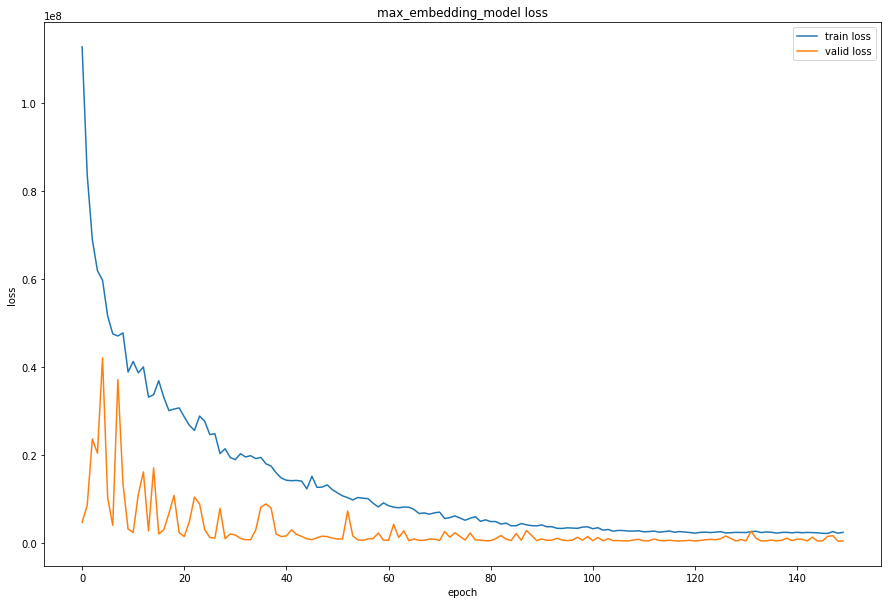

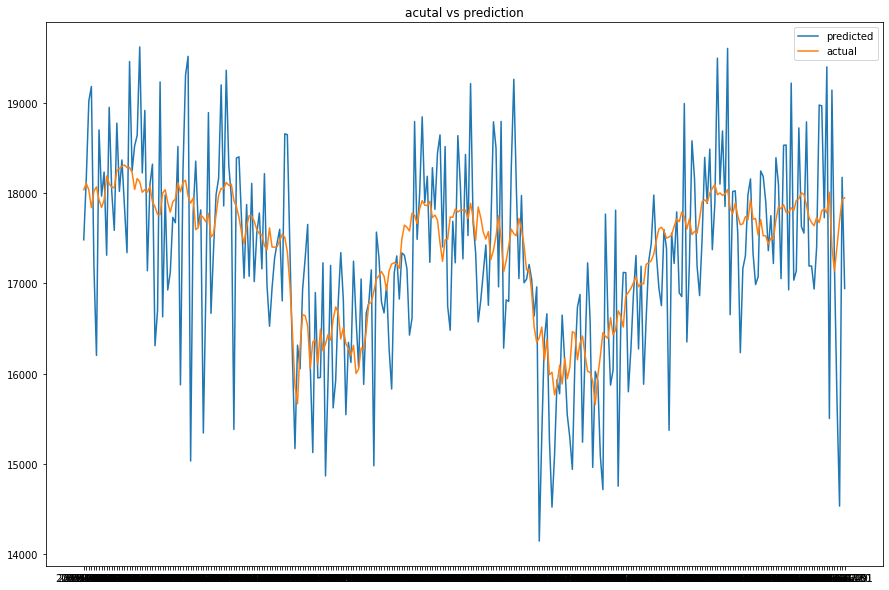

In [50]:
# summarize history for loss
plt.figure(figsize=(15,10))
plt.plot(max_embedding_history.history['loss'])
plt.plot(max_embedding_history.history['val_loss'])
plt.title('max_embedding_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

predicted_close_price = max_embedding_model.predict([max_embedding_test, open_price_test])

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(predicted_close_price)
plt.plot(adj_close_price_test)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [52]:
combined_embedding_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [53]:
combined_embedding_history = combined_embedding_model.fit({'combined': combined_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=150, validation_split=0.1, verbose=1)

Epoch 1/150
95/95 [==============================] - 1s 5ms/step - loss: 36416.0938 - root_mean_squared_error: 39724.3359 - val_loss: 19310.5645 - val_root_mean_squared_error: 19334.1445
Epoch 2/150
95/95 [==============================] - 0s 2ms/step - loss: 30575.8926 - root_mean_squared_error: 31865.7480 - val_loss: 17176.7051 - val_root_mean_squared_error: 17185.5371
Epoch 3/150
95/95 [==============================] - 0s 3ms/step - loss: 26943.0391 - root_mean_squared_error: 28560.5840 - val_loss: 17595.7715 - val_root_mean_squared_error: 17602.6562
Epoch 4/150
95/95 [==============================] - 0s 2ms/step - loss: 25352.7422 - root_mean_squared_error: 27027.7500 - val_loss: 17554.4785 - val_root_mean_squared_error: 17560.1309
Epoch 5/150
95/95 [==============================] - 0s 2ms/step - loss: 23487.8418 - root_mean_squared_error: 24602.1895 - val_loss: 17991.3633 - val_root_mean_squared_error: 17996.9609
Epoch 6/150
95/95 [==============================] - 0s 2ms/step 

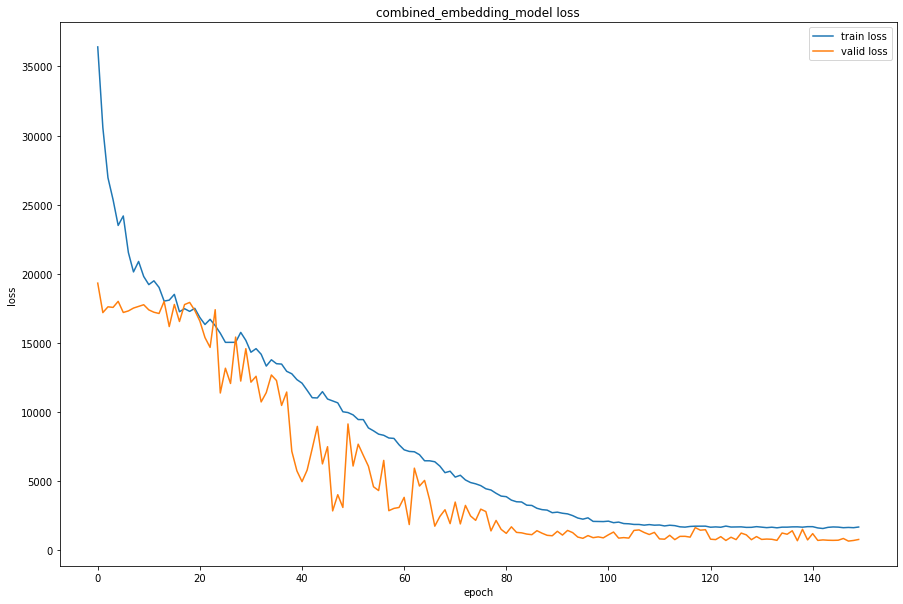

In [54]:
# summarize history for loss
plt.figure(figsize=(15,10))
plt.plot(combined_embedding_history.history['loss'])
plt.plot(combined_embedding_history.history['val_loss'])
plt.title('combined_embedding_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

In [55]:
predicted_close_price = combined_embedding_model.predict([combined_embedding_test, open_price_test])

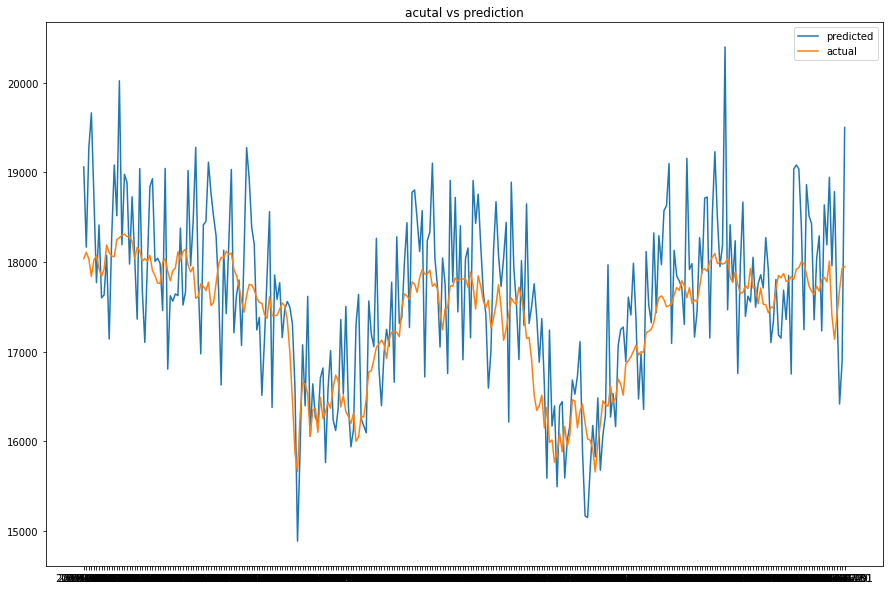

In [56]:
# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(predicted_close_price)
plt.plot(adj_close_price_test)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
combined_embedding_model.save("./combined_embedding_model")

INFO:tensorflow:Assets written to: ./combined_embedding_model/assets


In [70]:
# some further imporvements: (2021-09-20)
# Use DJIA-specific news headlines
# Maybe use RNN/GRU/LSTM for more powerful models
# High variance so restrict max difference between consecutive days